In [6]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
from torch.nn import functional as F
from sklearn.model_selection import train_test_split
from tqdm import tqdm_notebook as tqdm
%matplotlib notebook

In [26]:
Z_SIZE = 32
HR_LEN = 42
GSR_LEN = 480
INPUT_SIZE = HR_LEN + GSR_LEN
FILTERED_USERS = ['Javi', 'Alexa', 'Levent', 'Carlo']
FILTERED_USERS = [FILTERED_USERS[1]]

if torch.cuda.is_available():
    print('CUDA available.')
    device = torch.device("cuda")
else:
    print('CUDA not available.')
    device = torch.device("cpu")

# VAE code from: https://github.com/pytorch/examples/blob/master/vae/main.py

class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        h_size = 90
        self.fc1 = nn.Linear(INPUT_SIZE, h_size)
        self.fc21 = nn.Linear(h_size, Z_SIZE)
        self.fc22 = nn.Linear(h_size, Z_SIZE)
        self.fc3 = nn.Linear(Z_SIZE, h_size)
        self.fc4 = nn.Linear(h_size, INPUT_SIZE)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu)

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, INPUT_SIZE))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar
    
def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, INPUT_SIZE), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

def train(model, train_loader, optimizer, epoch, log_interval=int(1e9)):
    model.train()
    train_loss = 0
    for batch_idx, data in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        if batch_idx % log_interval == 0:
            continue
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.item() / len(data)))
    
    train_loss /= len(train_loader.dataset)
    # print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, train_loss))
    return train_loss

def test(model, test_loader, epoch):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for i, data in enumerate(test_loader):
            data = data.to(device)
            recon_batch, mu, logvar = model(data)
            test_loss += loss_function(recon_batch, data, mu, logvar).item()
    test_loss /= len(test_loader.dataset)
    # print('====> Test set loss: {:.4f}'.format(test_loss))
    return test_loss

CUDA available.


In [35]:
class ATDataset(torch.utils.data.Dataset):
    
    def __init__(self, data, augment_cycles=0):
        super(ATDataset).__init__()
        self.data = torch.from_numpy(data.astype(np.float32))
        self.augment_cycles = augment_cycles
    
    def __getitem__(self, index):
        item_i = index // (self.augment_cycles + 1)
        item = self.data[item_i]
        if self.augment_cycles > 0:
            return item + torch.randn(item.shape) * 0.1
        return item
    
    def __len__(self):
        return len(self.data) * (self.augment_cycles + 1)

def get_raw_data():
    import json
    from data_download import download_database
    raw_db = download_database()
    gsr_windows = []
    hr_windows = []
    for u in raw_db['users'].values():
        if u.get('first_name') not in FILTERED_USERS:
            continue
        for data_type in ['data', 'energy_data', 'quadrant_data']:
            data = u.get(data_type)
            if data is None:
                continue
            for entry in data.values():
                js_data = json.loads(entry['js_data'])
                snapshot = js_data['snapshot']
                gsr, hr = snapshot['gsr_samples'], snapshot['hr_samples']
                if len(gsr) > 0 and len(hr) > 0:
                    gsr_windows.append(gsr)
                    hr_windows.append(hr)
    assert len(gsr_windows) == len(hr_windows)
    return gsr_windows, hr_windows

def process_raw_data(gsr_windows, hr_windows, des_gsr_len, des_hr_len, use_scaler=True, use_normalizer=False):
    assert len(gsr_windows) == len(hr_windows)
    N = len(gsr_windows)
    D = des_gsr_len + des_hr_len
    res = np.zeros((N, D))
    from scipy.signal import resample
    from sklearn.preprocessing import StandardScaler, Normalizer
    normalizer = Normalizer()
    scaler = StandardScaler(copy=True, with_mean=True, with_std=True)
    for i in range(N):
        gsr = resample(gsr_windows[i], des_gsr_len)
        hr = resample(hr_windows[i], des_hr_len)
        assert gsr.size == des_gsr_len, hr.size == des_hr_len
        res[i, :des_gsr_len] = gsr
        res[i, des_gsr_len:] = hr
        
    if use_normalizer:
        res[:, :des_gsr_len] = normalizer.fit_transform(res[:, :des_gsr_len])
        res[:, des_gsr_len:] = normalizer.fit_transform(res[:, des_gsr_len:])
    if use_scaler:
        res = scaler.fit_transform(res)
    return res, scaler

In [37]:
# del data_
if 'data_' not in globals():
    gsr_windows_, hr_windows_ = get_raw_data()
    data_, scaler_ = process_raw_data(gsr_windows_, hr_windows_, GSR_LEN, HR_LEN, use_scaler=False, use_normalizer=True)
gsr_lens_ = [len(w) for w in gsr_windows_]
hr_lens_ = [len(w) for w in hr_windows_]
print(f'GSR mean window len: {np.mean(gsr_lens_)} (stdev: {np.std(gsr_lens_)})')
print(f'HR mean window len: {np.mean(hr_lens_)} (stdev: {np.std(hr_lens_)})')

GSR mean window len: 478.6829268292683 (stdev: 4.815822622484284)
HR mean window len: 46.08536585365854 (stdev: 27.12581401251879)


Training set size 69
Test set size 13


<IPython.core.display.Javascript object>


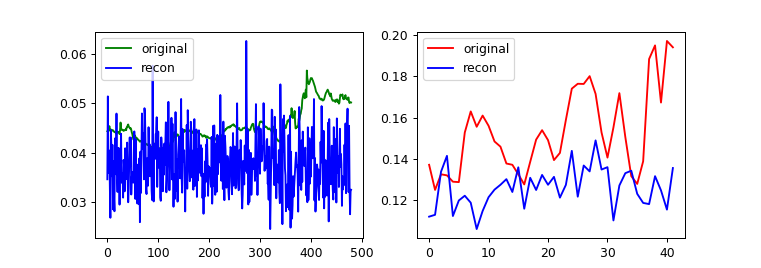

<IPython.core.display.Javascript object>


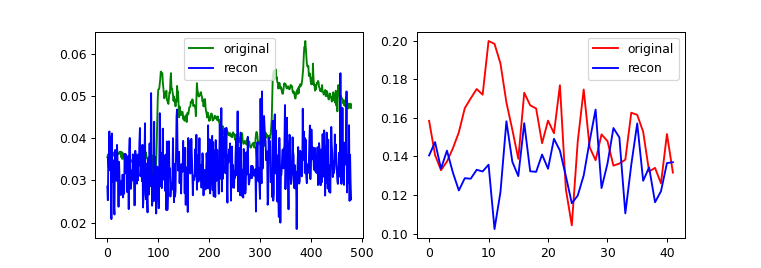

<IPython.core.display.Javascript object>


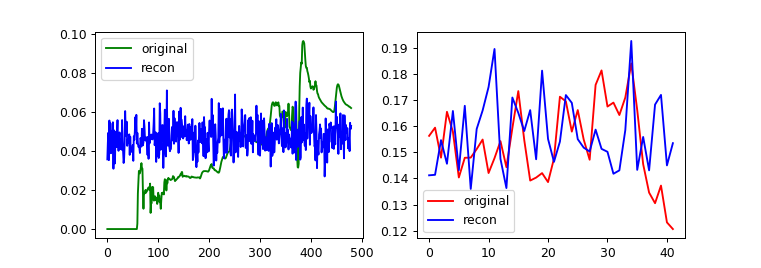

<IPython.core.display.Javascript object>


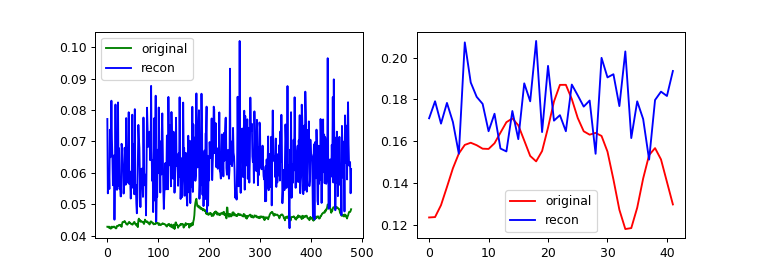

In [41]:
def main():
    torch.manual_seed(42)
    
    model = VAE().to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    batch_size = 16
    epochs = 1000
    
    np.random.seed(42)
    x_train, x_test = train_test_split(data_, test_size=0.15)
    train_ds = ATDataset(x_train, augment_cycles=0)
    test_ds = ATDataset(x_test)
    print('Training set size', len(train_ds))
    print('Test set size', len(test_ds))
    
    train_loader = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_ds, batch_size=batch_size, shuffle=True)
    
    train_losses = []
    test_losses = []
    
    for epoch in tqdm(range(1, epochs + 1), total=epochs):
        train_l = train(model, train_loader, optimizer, epoch)
        test_l = test(model, test_loader, epoch)
        train_losses.append(train_l)
        test_losses.append(test_l)
        
    for i in np.random.permutation(len(x_test))[:4]:
        with torch.no_grad():
            orig = train_ds[i].to(device)[None]
            recon = model.forward(orig)[0].cpu().numpy()
            if 'scaler_' in globals():
                orig_invt = scaler_.inverse_transform(orig.cpu().numpy())
                recon = scaler_.inverse_transform(recon)
            else:
                orig_invt = orig.cpu().numpy()
                
            
            fig, axes = plt.subplots(1, 2, figsize=(8.5, 3))

            axes[0].plot(orig_invt[0, :GSR_LEN], color='g', label='original')
            axes[0].plot(recon[0, :GSR_LEN], color='b', label='recon')
            axes[0].legend()
            
            axes[1].plot(orig_invt[0, GSR_LEN:], color='r', label='original')
            axes[1].plot(recon[0, GSR_LEN:], color='b', label='recon')
            axes[1].legend()
            fig.show()
    return model, train_losses, test_losses
model_, train_losses_, test_losses_ = main()

<IPython.core.display.Javascript object>


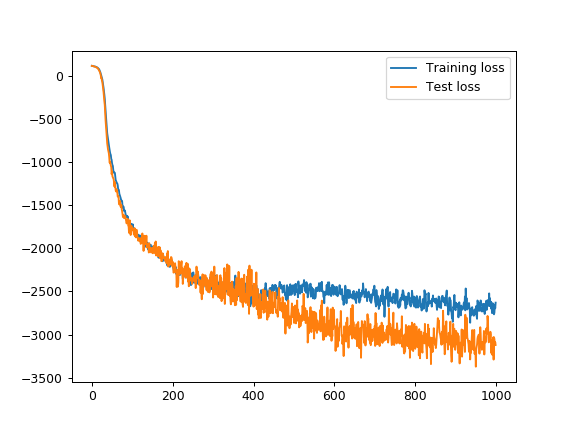

In [25]:
plt.figure()
plt.plot(train_losses_, label='Training loss')
plt.plot(test_losses_, label='Test loss')
plt.legend()
plt.show()

<IPython.core.display.Javascript object>


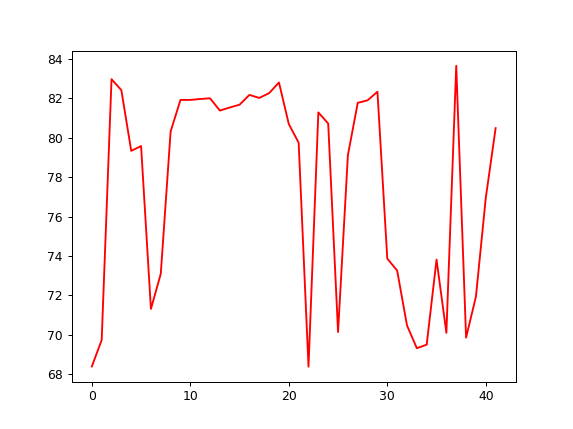

<IPython.core.display.Javascript object>


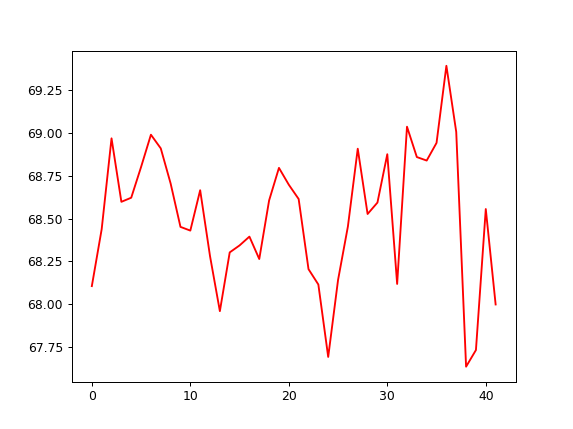

<IPython.core.display.Javascript object>


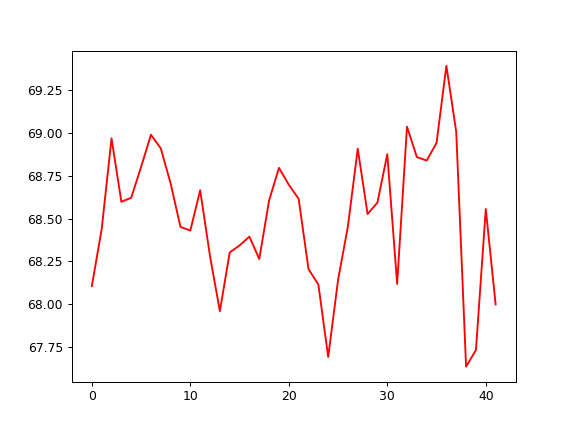

<IPython.core.display.Javascript object>


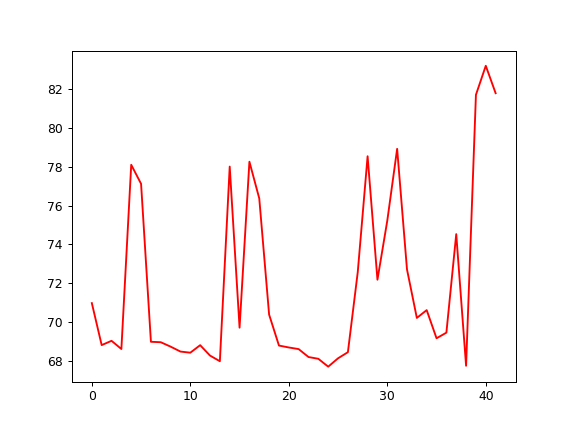

<IPython.core.display.Javascript object>


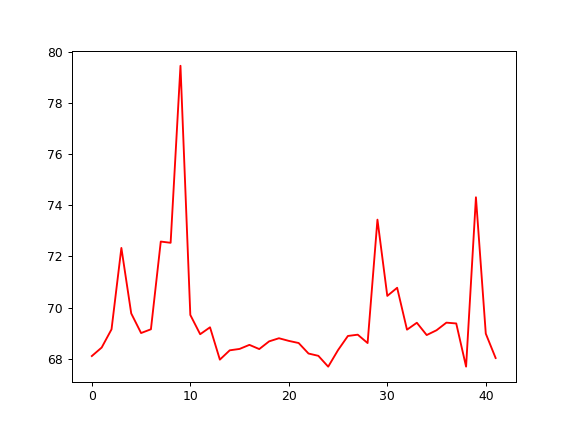

<IPython.core.display.Javascript object>


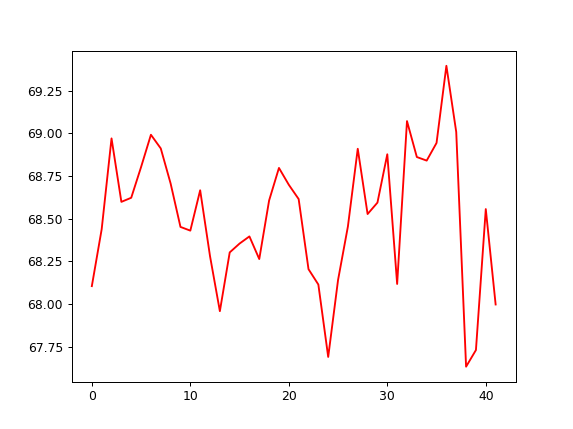

<IPython.core.display.Javascript object>


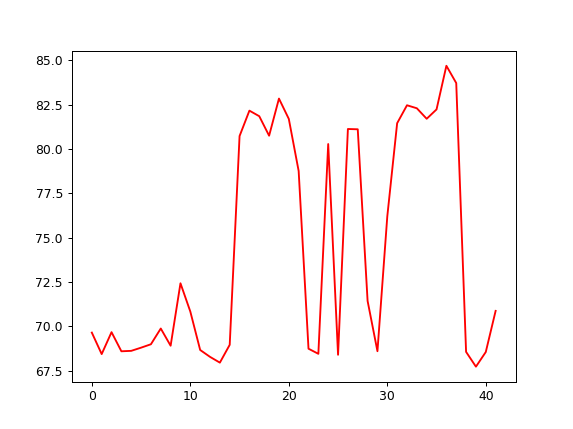

<IPython.core.display.Javascript object>


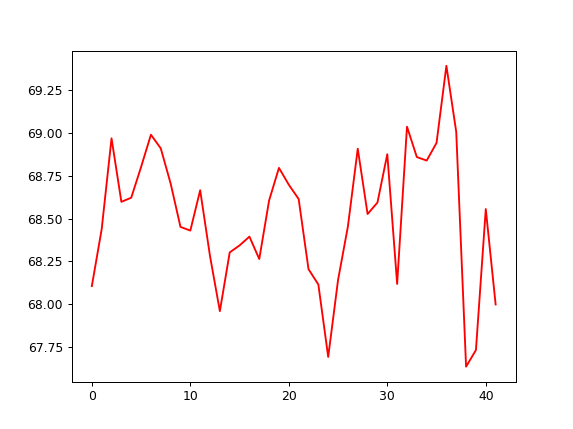

<IPython.core.display.Javascript object>


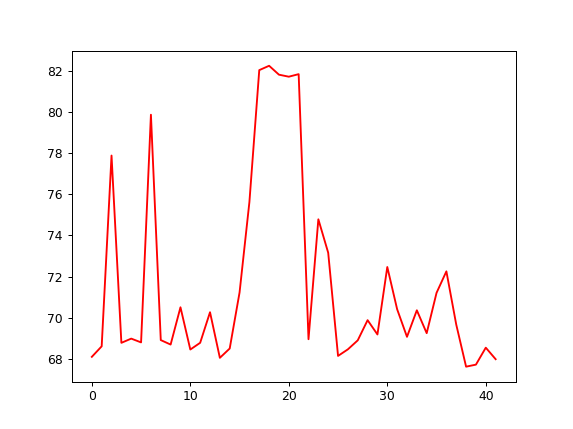

<IPython.core.display.Javascript object>


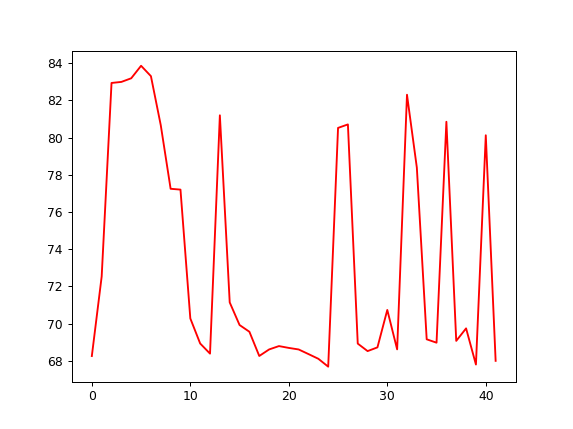

<IPython.core.display.Javascript object>


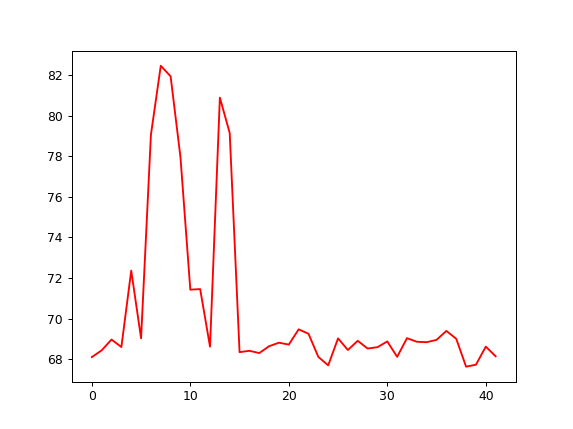

<IPython.core.display.Javascript object>


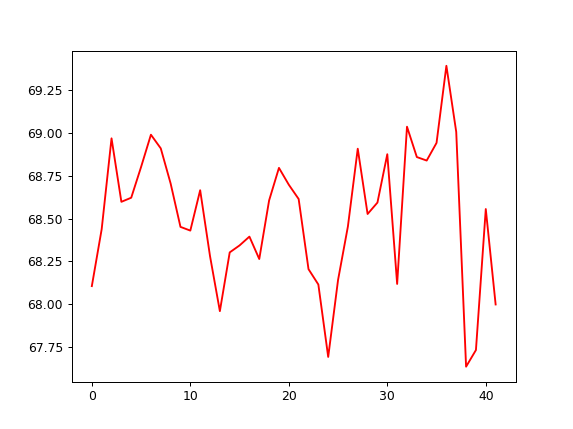

In [111]:
for i in range(4):
    for v in [-0.9, 0.0, 0.9]:
        with torch.no_grad():
            z = torch.randn(1, Z_SIZE).to(device)
            z[0, i] = v
            r = scaler_.inverse_transform(model_.decode(z).cpu().numpy())

        plt.figure()
        plt.plot(r[0, GSR_LEN:], color='r')
        plt.show()

In [46]:
np.random.normal(size=(1, 12))

array([[-0.61117443, -0.63622197,  0.81312403, -0.54148808, -0.85117572,
         2.1067368 , -0.09741509, -0.50831588,  0.39751891, -0.65639151,
         1.12914984, -0.53309849]])

<IPython.core.display.Javascript object>


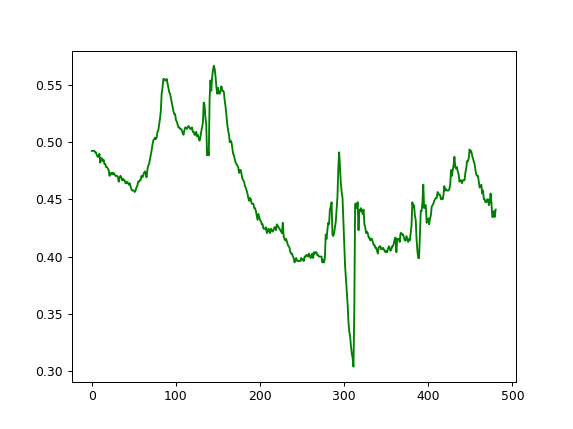

<IPython.core.display.Javascript object>


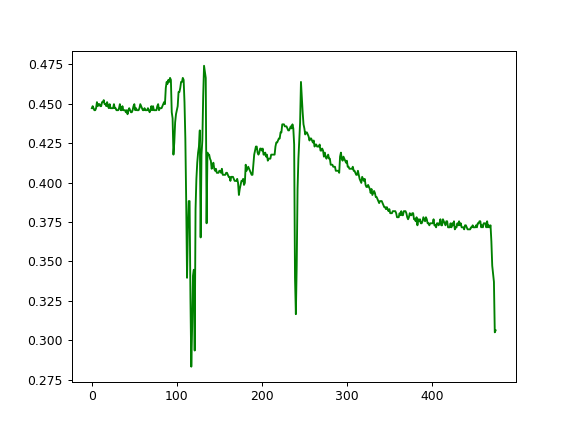

<IPython.core.display.Javascript object>


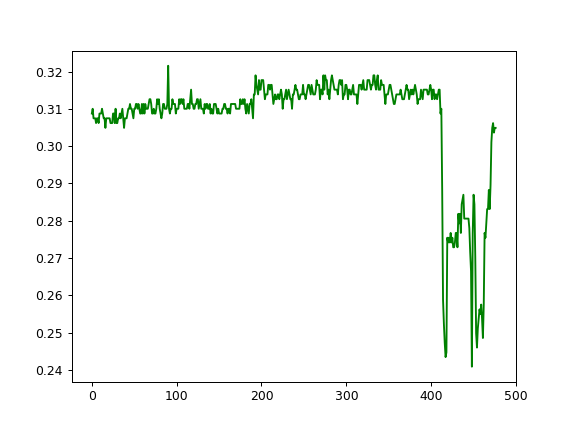

/home/carlo/Projects/AssistiveTech/at_env/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


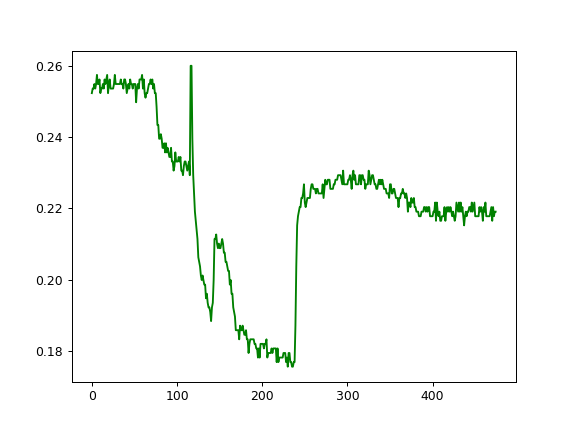

<IPython.core.display.Javascript object>


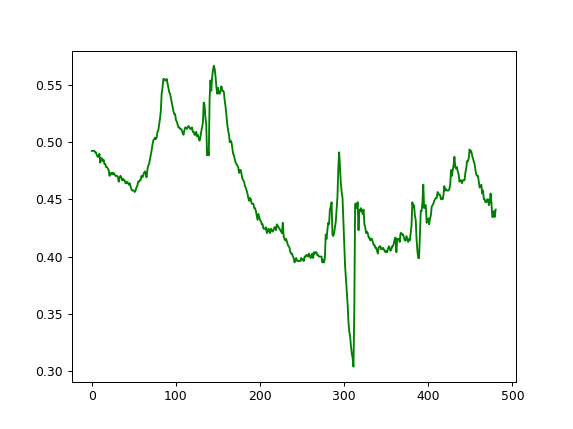

In [119]:
idx = np.random.choice(len(gsr_windows_), 5)
for i in idx:
    plt.figure()
    plt.plot(gsr_windows_[i], color='g')
    plt.show()